In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.colors import LinearSegmentedColormap
from collections import Counter
import cudf
import cuml

import warnings
warnings.filterwarnings('ignore') 

<div style="background-color: #65aeeb; color: white; border-left: 6px solid #b3d4fc; padding: 10px; font-size: 20px; font-family: Verdana;">
    <ul>
        <li>Use Cuml and sklearn to compare times</li>   
    </ul>  
</div>

In [2]:
!pip install colorama -q

In [3]:
from colorama import Fore, Style

In [4]:
df = cudf.read_csv("df.csv")

In [5]:
df.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 695073 entries, 0 to 695072
Data columns (total 43 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   0       695073 non-null  float64
 1   1       695073 non-null  float64
 2   2       695073 non-null  float64
 3   3       695073 non-null  float64
 4   4       695073 non-null  float64
 5   5       695073 non-null  float64
 6   6       695073 non-null  float64
 7   7       695073 non-null  float64
 8   8       695073 non-null  float64
 9   9       695073 non-null  float64
 10  10      695073 non-null  float64
 11  11      695073 non-null  float64
 12  12      695073 non-null  float64
 13  13      695073 non-null  float64
 14  14      695073 non-null  float64
 15  15      695073 non-null  float64
 16  16      695073 non-null  float64
 17  17      695073 non-null  float64
 18  18      695073 non-null  float64
 19  19      695073 non-null  float64
 20  20      695073 non-null  float64
 21  21      6950

In [6]:
df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,target
0,-1.710384,-1.010391,-1.411593,-2.328471,0.881562,0.415400,0.097792,0.868969,0.444528,0.000832,...,0.298227,-0.115664,0.824478,0.005400,0.018094,-0.022223,-0.636816,-1.385131,-2.711661,0
1,-1.710374,-1.010391,0.001092,-2.328471,0.849484,0.407832,0.138192,0.861241,0.399423,0.077110,...,0.292599,-0.126193,0.815816,-0.011864,-0.010068,-0.009401,-0.592041,-1.382887,-2.726381,0
2,-1.710364,-1.010391,0.001092,-2.328471,0.881795,0.415471,0.108071,0.845683,0.396348,0.101189,...,0.295401,-0.120932,0.815765,-0.000734,-0.000363,0.006405,-0.621700,-1.400107,-2.721543,0


<div style="background-color: #65aeeb; color: white; border-left: 6px solid #b3d4fc; padding: 10px; font-size: 15px; font-family: Verdana;">
    <ul>
        <li>Logisitic Regression</li>
        <li>SVM</li>
        <li>Random Forest</li>
    </ul>  
</div>

In [7]:
import time

class Timer:    
    def __enter__(self):
        self.tick = time.time()
        return self
    def __exit__(self, *args, **kwargs):
        self.tock = time.time()
        self.elapsed = self.tock - self.tick

In [8]:
from cuml.common.device_selection import using_device_type, set_global_device_type
set_global_device_type("GPU")

In [9]:
from cuml.linear_model import Ridge, Lasso, ElasticNet, LogisticRegression
from cuml.ensemble import RandomForestClassifier as cuRF
from cuml import TSNE
from cuml.svm import LinearSVC, SVC
from cuml.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import pickle

In [10]:
!pip install xgboost catboost -q

In [11]:
from xgboost import XGBClassifier, XGBRFClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb

In [12]:
def plot_model_roc_auc_curve(models_list:list, test_df= []):
    if (test_df == []):
        return
        
    test_df_np = test_df.to_numpy() if isinstance(test_df, cudf.DataFrame) else test_df
    true_values = test_df['True'].to_numpy() if isinstance(test_df['True'], cudf.Series) else test_df['True']
    predictions_list = [test_df[model].to_numpy() if isinstance(test_df[model], cudf.Series) else test_df[model] for model in models_list]
    
    # Plot ROC curves
    plt.figure(figsize=(7, 5))
    for model, preds in zip(models_list, predictions_list):
        fpr, tpr, _ = roc_curve(true_values, preds)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{model} (AUC = {roc_auc:.2f})')

    # Plot random guess line
    plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')

    # Set labels and title
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Two Models')
    plt.legend()
    plt.show()

In [13]:
"""from dask_cuda import LocalCUDACluster
from dask.distributed import Client

cluster = LocalCUDACluster(threads_per_worker=1, n_workers=n_workers)
c = Client(cluster)
workers = c.has_what().keys()"""

'from dask_cuda import LocalCUDACluster\nfrom dask.distributed import Client\n\ncluster = LocalCUDACluster(threads_per_worker=1, n_workers=n_workers)\nc = Client(cluster)\nworkers = c.has_what().keys()'

In [14]:
from catboost.utils import get_gpu_device_count
print('I see %i GPU devices' % get_gpu_device_count())

I see 1 GPU devices


In [15]:
X = df.drop(columns=['target'])
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Logisitic Regression
Training set performance
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    300577
           1       1.00      1.00      1.00    255482

    accuracy                           1.00    556059
   macro avg       1.00      1.00      1.00    556059
weighted avg       1.00      1.00      1.00    556059

Roc-Auc Score Training set: 0.9996442023800126
Test set performance
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     75144
           1       1.00      1.00      1.00     63870

    accuracy                           1.00    139014
   macro avg       1.00      1.00      1.00    139014
weighted avg       1.00      1.00      1.00    139014

Roc-Auc Score Test set: 0.9996903874731176
_._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._.
SVM
Training set performance
              precision    recall  f1-score   support

           0       1.00 

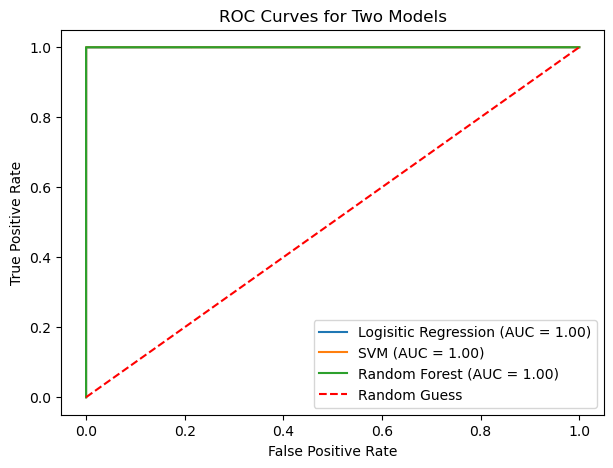

Fit + Predict time (seconds): 117.22464847564697


In [16]:
models={
    "Logisitic Regression":LogisticRegression(),
    "SVM": SVC(probability=True),
    "Random Forest":cuRF()
}
predictions={'True': y_test}
target_names=['0','1']
with Timer() as models_time:
    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train, y_train) # Train model
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        print(list(models.keys())[i])
        predictions[list(models.keys())[i]] = model.predict_proba(X_test).iloc[:, 1]      
        print("Training set performance")
        y_train = y_train.to_numpy() if isinstance(y_train, cudf.Series) else y_train
        y_train_pred = y_train_pred.to_numpy() if isinstance(y_train_pred, cudf.Series) else y_train_pred
        # Print classification report
        print(classification_report(y_train, y_train_pred, target_names=target_names))
        model_train_rocauc_score = roc_auc_score(y_train, y_train_pred)
        print(f"Roc-Auc Score Training set: {model_train_rocauc_score}")
        print("Test set performance")
        y_test = y_test.to_numpy() if isinstance(y_test, cudf.Series) else y_test
        y_test_pred = y_test_pred.to_numpy() if isinstance(y_test_pred, cudf.Series) else y_test_pred
        print(classification_report(y_test, y_test_pred, target_names=target_names))
        model_test_rocauc_score = roc_auc_score(y_test, y_test_pred) #Calculate Roc
        print(f"Roc-Auc Score Test set: {model_test_rocauc_score}")
        print(f"{Fore.BLUE}{Style.BRIGHT}_."*40) # print 50 times = character
        print(Style.RESET_ALL, end="")
    plot_model_roc_auc_curve(list(models.keys()), predictions)
print(f"Fit + Predict time (seconds): {models_time.elapsed}")

In [17]:
pickle.dump(cuRF, open("cuRF.pkl", "wb"))
del cuRF

<div style="background-color: #65aeeb; color: white; border-left: 6px solid #b3d4fc; padding: 10px; font-size: 12px; font-family: Verdana;">
    <ul>
        <li>To compare Sklearn models on a per minute basis</li>
    </ul>  
</div>

In [ ]:
import sys
import gc

for name in list(sys.modules.keys()):
    if name not in ["__main__", "builtins"]:
        del sys.modules[name]

for name in list(globals().keys()):
    if name not in ["__builtins__", "__name__", "__doc__", "__package__", "__file__", "__cached__"]:
        del globals()[name]
gc.collect()
print("All imports and variables in the environment have been cleared.")

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.colors import LinearSegmentedColormap
from collections import Counter
!pip install colorama -q
from colorama import Fore, Style

from sklearn.linear_model import LogisticRegression as sklearnLogisticRegression
from sklearn.ensemble import RandomForestClassifier as sklearnRandomForestClassifier
from sklearn.svm import SVC as sklearnSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc

In [2]:
import time

class Timer:    
    def __enter__(self):
        self.tick = time.time()
        return self
    def __exit__(self, *args, **kwargs):
        self.tock = time.time()
        self.elapsed = self.tock - self.tick

In [3]:
df = pd.read_csv("df.csv")
X = df.drop(columns=['target'])
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [4]:
def plot_model_roc_auc_curve_sklearn(models_list:list, test_df):
    plt.figure(figsize=(7, 5))

    for model in models_list:
        fpr, tpr, _ = roc_curve(test_df['True'], test_df[model])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{model} (AUC = {roc_auc:.2f})')

    # Plot random guess line
    plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')

    # Set labels and title
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Two Models')
    plt.legend()
    plt.show()

In [ ]:
models={
    "Logisitic Regression":sklearnLogisticRegression(n_jobs=-1),
    "SVM": sklearnSVC(probability=True),
    "Random Forest":sklearnRandomForestClassifier(n_jobs=-1)
}
predictions={'True': y_test}
target_names=['0','1']
with Timer() as models_time:
    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train, y_train) # Train model
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        print(list(models.keys())[i])
        predictions[list(models.keys())[i]] = model.predict_proba(X_test)[:, 1]      
        print("Training set performance")
        
        # Print classification report
        print(classification_report(y_train, y_train_pred, target_names=target_names))
        model_train_rocauc_score = roc_auc_score(y_train, y_train_pred)
        print(f"Roc-Auc Score Training set: {model_train_rocauc_score}")
        print("Test set performance")
       
        print(classification_report(y_test, y_test_pred, target_names=target_names))
        model_test_rocauc_score = roc_auc_score(y_test, y_test_pred) #Calculate Roc
        print(f"Roc-Auc Score Test set: {model_test_rocauc_score}")
        print(f"{Fore.BLUE}{Style.BRIGHT}_."*40) # print 50 times = character
        print(Style.RESET_ALL, end="")
    plot_model_roc_auc_curve_sklearn(list(models.keys()), predictions)
print(f"Fit + Predict time (seconds): {models_time.elapsed}")

Logisitic Regression
Training set performance
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    300577
           1       1.00      1.00      1.00    255481

    accuracy                           1.00    556058
   macro avg       1.00      1.00      1.00    556058
weighted avg       1.00      1.00      1.00    556058

Roc-Auc Score Training set: 0.9995590681223095
Test set performance
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     75144
           1       1.00      1.00      1.00     63871

    accuracy                           1.00    139015
   macro avg       1.00      1.00      1.00    139015
weighted avg       1.00      1.00      1.00    139015

Roc-Auc Score Test set: 0.9996066297157902
_._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._.


<div style="background-color: #65aeeb; color: white; border-left: 6px solid #b3d4fc; padding: 10px; font-size: 12px; font-family: Verdana;">
    <ul>
        <li>I don't want to wait for Sklearn to finish. It takes more than 1 hour. I have plotted the times approximate.</li>
    </ul>  
</div>

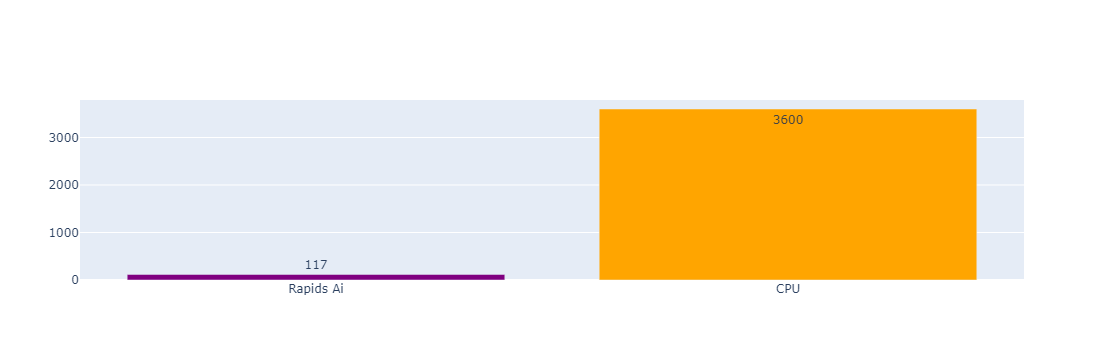

In [14]:
import plotly.graph_objects as go

x = ['Rapids Ai', 'CPU']
y = [117, 3600]

fig = go.Figure(data=[go.Bar(x=x, y=y, text=y, textposition='auto', marker=dict(color=[ 'purple', 'orange']))])
fig.show()

<div style="background-color: #eb347a; color: white; border-left: 6px solid #b3d4fc; padding: 10px; font-size: 14px; font-family: Verdana;">
    <ul>
        <li>In conclusion, rapids ai more faster than sklearn. You can use it in large dataset to speed up your process.</li>
    </ul>  
</div>

In [ ]:
# end